Instalacion H5PY para guardar en formato binario el modelo

In [0]:
!pip install h5py

Montamos la unidad de Drive e importamos algunos paquete necesarios para la ejecucion

In [2]:
import pandas as pd
import numpy as np
import gzip
import pickle
from google.colab import drive
from pathlib import Path
import cv2

drive.mount( '/content/drive' )

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Metodo para leer los subdirectorios de una ruta

In [0]:
def ls( ruta = Path.cwd() ):
    return [ arch.name for arch in Path(ruta).iterdir() if arch.is_file() ]

X_train

In [0]:
X_train = list()
with open( "/content/drive/My Drive/Colab Notebooks/TPFinal/dataset.txt", "r" ) as file:
  line = file.readline()
  while ( line != '' ):
    ruta  = "/content/drive/My Drive/Cohn-kanade-dataset/" + str( line[:4] ) + '/' + str( line[5:8] ) + '/'
    lista = ls( ruta )
    for i in range(len(lista)-5 , len(lista) ):
      if( i != len(lista)-1 ):       
        img = cv2.resize(cv2.imread( ruta + lista[i] ), (48,48) )
        X_train.append( img/255 )
    line = file.readline()

with gzip.open( "/content/drive/My Drive/Colab Notebooks/TPFinal/X_train-5.pkl.gz", "wb" ) as of:
	pickle.dump(np.array(X_train,dtype='float32'),of, pickle.HIGHEST_PROTOCOL)

y_train

In [0]:
y_train = list()
with open("/content/drive/My Drive/Colab Notebooks/TPFinal/dataset.txt","r") as file:
    line = file.readline()
    while ( line != '' ):
        ruta  = "/content/drive/My Drive/Cohn-kanade-dataset/" + str( line[:4] ) + '/' + str( line[5:8] ) + '/'
        lista = ls( ruta )
        for i in range(len(lista)-5 , len(lista) ):
          if( i != len(lista)-1 ):       
            y_train.append( (int) (line[9:]) )
        line = file.readline()
        
with gzip.open("/content/drive/My Drive/Colab Notebooks/TPFinal/y_train.pkl.gz","wb") as of:
	pickle.dump(np_utils.to_categorical(y_train),of, pickle.HIGHEST_PROTOCOL)


X_test

In [0]:
X_train = list()
with open( "/content/drive/My Drive/Colab Notebooks/TPFinal/dataset.txt", "r" ) as file:
  line = file.readline()
  while ( line != '' ):
    ruta  = "/content/drive/My Drive/Cohn-kanade-dataset/" + str( line[:4] ) + '/' + str( line[5:8] ) + '/'
    lista = ls( ruta )
    for i in range(len(lista)-5 , len(lista) ):
      if( i == len(lista)-1 ):       
        img = cv2.resize( cv2.imread( ruta + lista[i] ), (48,48) )
        X_train.append( img/255 )
    line = file.readline()

with gzip.open( "/content/drive/My Drive/Colab Notebooks/TPFinal/X_train-5.pkl.gz", "wb" ) as of:
	pickle.dump(np.array(X_train,dtype='float32'),of, pickle.HIGHEST_PROTOCOL)

y_test

In [0]:
y_train = list()
with open( "/content/drive/My Drive/Colab Notebooks/TPFinal/dataset.txt", "r" ) as file:
    line = file.readline()
    while ( line != '' ):
        ruta  = "/content/drive/My Drive/Cohn-kanade-dataset/" + str( line[:4] ) + '/' + str( line[5:8] ) + '/'
        lista = ls( ruta )
        for i in range(len(lista)-5 , len(lista) ):
          if( i == len(lista)-1 ):       
            y_train.append( (int) (line[9:]) )
        line = file.readline()
        
with gzip.open( "/content/drive/My Drive/Colab Notebooks/TPFinal/y_train.pkl.gz", "wb" ) as of:
	pickle.dump(np_utils.to_categorical(y_train),of, pickle.HIGHEST_PROTOCOL)

Eliminamos las varaibles

In [0]:
del(X_train)
del(y_train)
del(img)
del(ruta)
del(lista)
del(line)

Levantamos X_train e y_train previamente procesados

In [6]:
from keras.utils import np_utils
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding
from keras.optimizers import SGD, adam

X_train, y_train = list(),list()

f = gzip.open( "/content/drive/My Drive/Colab Notebooks/TPFinal/X_train-5.pkl.gz", 'rb' )
#f = gzip.open( "/content/drive/My Drive/Colab Notebooks/TPFinal/X_train-5.pkl.gz", 'rb' )
X_train = pickle.load(f)
f.close()

f = gzip.open( "/content/drive/My Drive/Colab Notebooks/TPFinal/y_train.pkl.gz", 'rb' )
#f = gzip.open( "/content/drive/My Drive/Colab Notebooks/TPFinal/y_train.pkl.gz", 'rb' )
y_train = pickle.load(f)
f.close()

  
X_train = np.array( X_train, dtype = 'float32' )
y_train = np.array( y_train, dtype = 'int16' )

print( X_train.shape )
print( y_train.shape )
#print( np.round (X_train[0],2))
#print( X_train[0].shape )

(1308, 48, 48, 3)
(1308, 7)


Modulo para saca las caracteristicas de cada imagen

In [0]:
vgg16 = VGG16( include_top = False, input_shape = (48, 48, 3), weights = 'imagenet' )

def get_vgg16_output( vgg16, array_input, n ):
  picture_train_features = vgg16.predict( array_input )
  feature_map = np.empty( [n, 512] )
  for idx_pic, picture in enumerate( picture_train_features ):
      feature_map[idx_pic] = picture
  return feature_map

x_train = get_vgg16_output( vgg16, X_train, len(X_train) )
print( x_train.shape )
print( x_train[0])
#print( np.round(x_train[0],2) )
#print(x_train[0].shape)


In [0]:
import numpy as np

'''img = raw_data["pixels"][0] # first image
val = img.split(" ")
x_pixels = np.array(val, 'float32')
x_pixels /= 255 '''
x = x_train[0]#[:484]
#print(x)
x_reshaped = x 
#.reshape(22,22)

#%matplotlib inline # only if running in jupyter notebook
import matplotlib
import matplotlib.pyplot as plt
plt.imshow(x_reshaped, cmap= "gray", interpolation="nearest")    
plt.axis("off")
plt.show()

Modelo

In [0]:
Model = Sequential()
Model.add( Dense( 256, input_shape = (512,), activation = 'relu' ) )
Model.add( Dense( 256, input_shape = (256,), activation = 'relu' ) )
Model.add( Dropout( 0.5 ) )
Model.add( Dense( 128, input_shape = (256,), activation = 'relu' ) )
Model.add( Dense( 7, activation = 'softmax' ) )

Model.compile( loss = 'categorical_crossentropy', optimizer = adam(), metrics = ['accuracy'] )
Model.fit( x_train, y_train, validation_data = ( x_train, y_train ), epochs = 35, batch_size = 10 )  

In [0]:
Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 903       
Total params: 230,919
Trainable params: 230,919
Non-trainable params: 0
_________________________________________________________________


Levantamos X_train e y_train previamente procesados

In [0]:
X_test, y_test = list(),list()

#f = gzip.open("/content/drive/My Drive/Colab Notebooks/TPFinal/X_test-5.pkl.gz", 'rb')
f = gzip.open("/content/drive/My Drive/TPFinal/X_test-5.pkl.gz", 'rb')
X_test = pickle.load(f)
f.close()

#f = gzip.open("/content/drive/My Drive/Colab Notebooks/TPFinal/y_test.pkl.gz", 'rb')
f = gzip.open("/content/drive/My Drive/TPFinal/y_test.pkl.gz", 'rb')
y_test = pickle.load(f)
f.close()
  
X_test = np.array( X_test, dtype = 'float32' )
y_test = np.array( y_test, dtype = 'int16' )

print( X_test.shape )
print( y_test.shape )

x_test = get_vgg16_output(vgg16, X_test, len( X_test ) )

(327, 48, 48, 3)
(327, 7)


Prueba y precision

In [0]:
scores = Model.evaluate( x_test ,y_test )
print( "\n%s: %.2f%%" %( Model.metrics_names[1], scores[1] * 100 ) )
print( Model.metrics_names )
print( scores )

327/327 [==============================] - 0s 80us/step

acc: 96.94%
['loss', 'acc']
[0.07744743140123853, 0.9694189602446484]


Matriz de confucion

In [0]:
y_pred = Model.predict_classes ( x_test )
print( x_test.shape )

#Nos permite volver a ver el valor numerico perteneciente a la categoria correspondiente
y_classes = [ np.argmax( y, axis=None, out=None ) for y in y_test ] 

n_columns = n_row = 7
matrix = [ [0] * n_columns for i in range(n_row) ]
matrix = np.array( matrix )
for k in range( len( y_pred ) ):
  matrix[ int(y_classes[k]) ][ int(y_pred[k]) ] += 1 
print( matrix )
print ( "Precision: " + str( float( np.trace( np.array( matrix ) ) ) / len(y_pred) ) )

(327, 512)
[[42  0  1  0  0  2  0]
 [ 0 18  0  0  0  0  0]
 [ 0  0 59  0  0  0  0]
 [ 0  0  0 25  0  0  0]
 [ 0  0  0  0 69  0  0]
 [ 0  0  1  0  0 27  0]
 [ 0  0  1  0  1  0 81]]
Precision: 0.981651376146789


327/327 [==============================] - 0s 46us/step


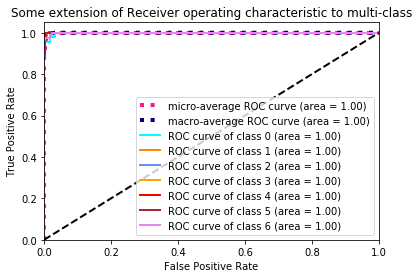

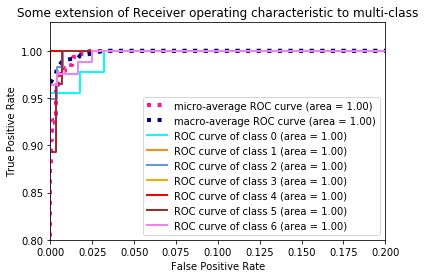

In [0]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes = 7

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
pred = Model.predict(x_test, batch_size=32, verbose=1)
predicted = np.argmax(pred, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','orange','red','brown','violet'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.03)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','orange','red','brown','violet'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Modulo para guardar y levantar el modelo

In [0]:
from keras.models import model_from_json

model_json = Model.to_json()
with open( "/content/drive/My Drive/Colab Notebooks/TPFinal/model.json", "w" ) as json_file:
  json_file.write( model_json )
  
#serializan los pesos (weights) para HDF5
Model.save_weights( "/content/drive/My Drive//Colab Notebooks/TPFinal/model.h5" )
print( "Modelo guardado en el PC" )

In [0]:
# carga el json y crea el modelo
json_file = open( '/content/drive/My Drive/Colab Notebooks/TPFinal/model.json', 'r' )
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# se cargan los pesos (weights) en el nuevo modelo
loaded_model.load_weights( "/content/drive/My Drive/Colab Notebooks/TPFinal/model.h5" )
print( "Modelo cargado desde el PC" )

In [0]:
from keras.utils import np_utils
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding
from keras.optimizers import SGD, adam

# se evalua el modelo cargado con los datos de los test
loaded_model.compile( loss = 'categorical_crossentropy', optimizer = adam(), metrics=['accuracy'] )

score = loaded_model.evaluate( x_test, y_test, verbose = 0 )
print("%s: %.2f%%" % ( loaded_model.metrics_names[1], score[1]*100 ) )

acc: 98.17%


Prueba del modulo anterior

In [0]:
y_pred = loaded_model.predict_classes( x_test )
n_columns = n_row = 7
y_classes = [ np.argmax( y, axis=None, out=None ) for y in y_test ] 
confusion = [ [0] * n_columns for i in range(n_row) ]
confusion = np.array( confusion )
for k in range( len(y_pred) ):
  confusion[ int(y_classes[k]) ][ int(pred[k]) ] += 1
print( confusion )
print( "Precision: " + str( float( np.trace( np.array( confusion ) ) ) / len(y_pred) ) )

[[44  0  0  0  0  1  0]
 [ 0 18  0  0  0  0  0]
 [ 0  0 59  0  0  0  0]
 [ 0  0  0 25  0  0  0]
 [ 0  0  0  0 69  0  0]
 [ 0  0  0  0  0 28  0]
 [ 2  0  1  0  1  1 78]]
Precision: 0.981651376146789


Pruebas Aleatorias

In [0]:
diccionary = { 0:'Enojo', 1:'Desprecio', 2:'Disgusto', 3:'Miedo', 4:'Tristeza', 5:'Alegría', 6:'Sorpresa' }

Emocion: Miedo


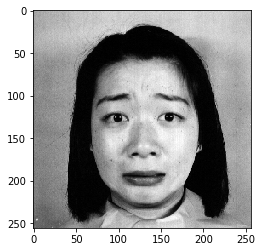

Emocion: Miedo


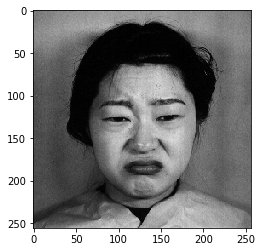

Emocion: Desprecio


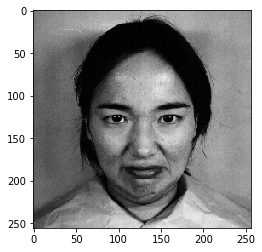

Emocion: Sorpresa


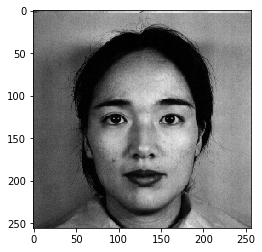

Emocion: Desprecio


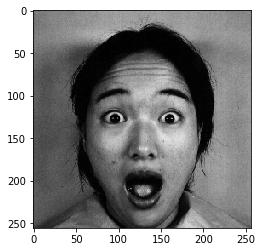

Emocion: Desprecio


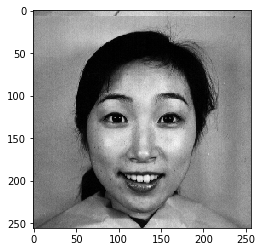

In [0]:
from google.colab.patches import cv2_imshow

X_test = list()
view = []
d = []
path = "/content/drive/My Drive/Prueba/"
for img in ls(path):
  view.append( cv2.imread( path+img ) ) 
  X_test.append( cv2.resize( cv2.imread( path+img ), (48,48) )/255 )

X_test = np.array( X_test, dtype = 'float32' )
x_test = get_vgg16_output(vgg16, X_test, len( X_test ) )
pred = loaded_model.predict_classes( x_test )

from matplotlib import pyplot as plt
for i in range( len(pred) ):
  print( "Emocion: "+ diccionary[pred[i]])
  plt.imshow(view[i])
  plt.show()
  